In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ks_2samp
import pandas as pd 
from scipy.stats import wasserstein_distance

dynamics_feat = {
    'GNM_Ventropy_full': r'Entropy$_v$', 'GNM_rmsf_overall_full': r'RMSF$_{all}$', 
    'GNM_Eigval1_full': r'$\lambda_1$', 'GNM_Eigval2_full': r'$\lambda_2$',
    'GNM_Eigval5_1_full': r'$\lambda_{5-1}$', 'GNM_SEall_full': r'SE$_{all}$',
    'GNM_SE20_full': r'SE$_{20}$', 'GNM_V1_full': r'$‖V_{1,i}‖$',
    'GNM_rankV1_full': r'rank ($‖V_{1,i}‖$)', 'GNM_V2_full': r'$‖V_{2,i}‖$',
    'GNM_rankV2_full': r'rank ($‖V_{2,i}‖$)', 'GNM_co_rank_full': r'rank ($‖C_{i,i}‖$)',
    'GNM_displacement_full': r'$‖C_{i,i}‖$', 'GNM_MC1_full': r'MC${_1}$',
    'GNM_MC2_full': r'MC${_2}$', 'ANM_effectiveness_chain': r'Effectiveness$^*$',
    'ANM_sensitivity_chain': r'Sensitivity$^*$',
    'ANM_stiffness_chain': r'Stiffness$^*$'
    # 'wtBJCE': r'wtBJCE', 'deltaBJCE': r'$\Delta$BJCE'
}
structure_feat = {
    'chain_length': r'Protein Size', 
    'Rg': r'R$_g$', 'DELTA_Rg': r'$\Delta$R$_g$',
    'AG1': r'AG$_1$', 'AG3': r'AG$_3$', 'AG5': r'AG$_5$', 
    'ACR': r'ACR', 'DELTA_ACR': r'$\Delta$ACR',
    'SF1': r'SF$_1$', 'SF2': r'SF$_2$', 'SF3': r'SF$_3$',
    'loop_percent': r'%Loop', 'helix_percent': r'%Helix', 'sheet_percent': r'%Sheet',
    'Lside': r'L$_{side}$', 'deltaLside': r'$\Delta$L$_{side}$', # not availabel yet
    'IDRs': r'Disorderliness', 'dssp': r'DSSP', 'Dcom': r'D$_{com}$', 
    'SASA': r'SA', 'DELTA_SASA': r'$\Delta$SA', 
    'Hbond': r'N$_{H-bond}$', 'DELTA_Hbond': r'$\Delta$N$_{H-bond}$',
    'SSbond': r'N$_{SS-bond}$', 'DELTA_DSS': r'$\Delta$N$_{SS-bond}$',
}
seq_feat = {
    'wtPSIC': r'wtPSIC$^*$', 'deltaPSIC': r'$\Delta$PSIC$^*$', 
    'BLOSUM': r'BLOSUM$^*$', 'entropy': r'Entropy$^*$', 'ranked_MI': r'Ranked MI$^*$',
    'consurf': r'ConSurf', 'ACNR': r'ACNR',
    'phobic_percent': r'%Hydrophobic', 'delta_phobic_percent': r'$\Delta$%Hydrophobic',
    'philic_percent': r'%Hydrophilic', 'delta_philic_percent': r'$\Delta$%Hydrophilic',
    'charge': r'Charge', 'deltaCharge': r'$\Delta$Charge', 
    'polarity': r'Polarity', 'deltaPolarity': r'$\Delta$Polarity', 
    'charge_pH7': r'Charge$_{pH7}$', 'DELTA_charge_pH7': r'$\Delta$Charge$_{pH7}$',
}
cols = {**dynamics_feat, **structure_feat, **seq_feat}
print(len(dynamics_feat), len(structure_feat), len(seq_feat))
print(len(cols))

def plot_feature(df, feat_name, folder='.'):
    plt.figure(figsize=(9, 6))
    # Normalize the feature
    _pos = df[df['labels'] == 1][feat_name].values
    _neg = df[df['labels'] == 0][feat_name].values

    _pos = _pos[~pd.isnull(_pos)]
    _neg = _neg[~pd.isnull(_neg)]

    _pos_mean, _neg_mean = _pos.mean(), _neg.mean()
    _pos_std, _neg_std = _pos.std(), _neg.std()
    _pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

    w_dist = wasserstein_distance(
        (_pos - df[feat_name].mean()) / df[feat_name].std(),
        (_neg - df[feat_name].mean()) / df[feat_name].std()
    )
    t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
    KS_stat, KS_p_val = ks_2samp(_pos, _neg)
    if p_val <= 10**(-300):
        p_val = '≤1e-300'
    else:
        p_val = f'{p_val:.2e}'
    if KS_p_val <= 10**(-300):
        KS_p_val = '≤1e-300'
    else:
        KS_p_val = f'{KS_p_val:.2e}'
    txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

    _pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
    _neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
    sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
    sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
    plt.title(f'{cols[feat_name]}', fontsize=25)
    plt.xlabel('Value', fontsize=25)
    plt.ylabel('Probability', fontsize=25)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    legend = plt.legend(fontsize=15)

    # # Plot the text below the legend
    bbox = legend.get_window_extent()  # Bounding box in display space
    ax = plt.gca()  # Current axis
    bbox_axes = ax.transAxes.inverted().transform(bbox)
    # x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
    x_legend = bbox_axes[0][0]  # Left x-coordinate
    y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
    # Plot the text below the legend
    lines = txt_msg.split('\n')
    line_spacing = 0.06  # Try tuning this value
    for i, line in enumerate(lines):
        plt.text(x_legend, y_legend - i * line_spacing, line,
                fontsize=15, transform=plt.gca().transAxes, ha='left')
        # plt.text(x_legend+0.03, y_legend - i * line_spacing, line,
        #         fontsize=15, transform=plt.gca().transAxes, ha='left')
    # plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    print(f"{feat_name} is saved at {folder}/{feat_name}.png")
    plt.close()

def split_plot(df, feat_name, 
               ax1_ylim=None, ax2_ylim=None, 
               ax1_yticks=None, ax2_yticks=None,
               folder='.'):
    _pos = df[df['labels'] == 1][feat_name].values
    _neg = df[df['labels'] == 0][feat_name].values

    _pos = _pos[~pd.isnull(_pos)]
    _neg = _neg[~pd.isnull(_neg)]

    _pos_mean, _neg_mean = _pos.mean(), _neg.mean()
    _pos_std, _neg_std = _pos.std(), _neg.std()
    _pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))
    _pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
    _neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'

    w_dist = wasserstein_distance(
        (_pos - df[feat_name].mean()) / df[feat_name].std(),
        (_neg - df[feat_name].mean()) / df[feat_name].std()
    )
    t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
    KS_stat, KS_p_val = ks_2samp(_pos, _neg)
    if p_val <= 10**(-300):
        p_val = '≤1e-300'
    else:
        p_val = f'{p_val:.2e}'
    if KS_p_val <= 10**(-300):
        KS_p_val = '≤1e-300'
    else:
        KS_p_val = f'{KS_p_val:.2e}'
    txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

    # Define the height ratios, for example, 1:2 (ax1 is 1 unit high, ax2 is 2 units high)
    # plt.figure(figsize=(9, 6))
    height_ratios = [1, 2]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': height_ratios},
                                figsize=(9, 6))
    # plot the same data on both Axes: n_SAVs_per_UniProtID
    sns.histplot(_pos, bins=50, color='r', alpha=0.5, kde=False, ax=ax1, stat='probability', label=f'Pathogenic, {_pos_text}')
    sns.histplot(_pos, bins=50, color='r', alpha=0.5, kde=False, ax=ax2, stat='probability')

    sns.histplot(_neg, bins=50, color='b', alpha=0.5, kde=False, ax=ax1, stat='probability', label=f'Benign, {_neg_text}')
    sns.histplot(_neg, bins=50, color='b', alpha=0.5, kde=False, ax=ax2, stat='probability')

    # y-axis limits
    if ax1_ylim is not None:
        ax1.set_ylim(ax1_ylim)
    if ax2_ylim is not None:
        ax2.set_ylim(ax2_ylim)
    # y-axis sticks
    if ax1_yticks is not None:
        ax1.set_yticks(ax1_yticks)
    if ax2_yticks is not None:
        ax2.set_yticks(ax2_yticks)
    # Font size of x-axis and y-axis
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)
    # Hide the spines between ax1 and ax2
    ax1.spines.bottom.set_visible(False)
    ax1.spines.top.set_visible(False)
    ax1.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.spines.right.set_visible(False)
    # remove ticks of ax1
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # Set y-title for both ax1 and ax2 as Probability, but only show once for both
    # The tile should be in the middle of the two subplots
    ax1.set_ylabel('', fontsize=15)
    ax2.set_ylabel('Probability', fontsize=25)
    ax2.yaxis.set_label_coords(-0.12, 0.9)
    ax1.set_title(f'{cols[feat_name]}', fontsize=25)
    ax2.set_xlabel('Value', fontsize=25)
    # plt.title(f'{feat_name}', fontsize=25)
    # Draw the slanted lines
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0], transform=ax1.transAxes, **kwargs)
    ax2.plot([1], transform=ax2.transAxes, **kwargs)

    # Plot legend
    legend = ax1.legend(fontsize=15)
    # Plot the text below the legend
    bbox = legend.get_window_extent()  # Bounding box in display space
    ax = plt.gca()  # Current axis
    bbox_axes = ax.transAxes.inverted().transform(bbox)
    x_legend = bbox_axes[0][0]  # Left x-coordinate
    y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
    # Plot the text below the legend
    lines = txt_msg.split('\n')
    line_spacing = 0.1  # Try tuning this value
    for i, line in enumerate(lines):
        plt.text(x_legend, y_legend - i * line_spacing, line,
                fontsize=15, transform=plt.gca().transAxes, ha='left')
    plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    print(f"{feat_name} is saved at {folder}/{feat_name}.png")
    plt.close()

# cols = {k: v for k, v in cols.items() if k in df.columns}
# df = pd.read_csv('features_withNEWpfam_25Mar26.csv')
df = pd.read_csv('/mnt/nas_1/YangLab/loci/tandem/data/R20000/final_features.csv')
# df = df.rename(columns=cols)

# df[df['BLOSUM'].isna()][feats]
# # SAV_coords,entropy,ranked_MI,wtPSIC,deltaPSIC,BLOSUM,phobic_percent,delta_phobic_percent,charge,deltaCharge,polarity,deltaPolarity
# # P04745 378 D N, , ,-2.426 ,-0.1 ,1.0,55.959594,0.0,1.0,-1.0,13.0,-1.4
# # P04745 411 N I,,,-2.95,-1.04,-3.0,55.959594,0.0,0.0,0.0,11.6,-6.4

# df.loc[df['SAV_coords']=='P04745 378 D N', 'BLOSUM'] = 1
# df.loc[df['SAV_coords']=='P04745 378 D N', 'phobic_percent'] = 55.959594
# df.loc[df['SAV_coords']=='P04745 378 D N', 'delta_phobic_percent'] = 0.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'charge'] = 1.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'deltaCharge'] = -1.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'polarity'] = 13.0
# df.loc[df['SAV_coords']=='P04745 378 D N', 'deltaPolarity'] = -1.4
# df.loc[df['SAV_coords']=='P04745 378 D N', 'philic_percent'] = 100 - 55.959594
# df.loc[df['SAV_coords']=='P04745 378 D N', 'delta_philic_percent'] = 0.0

# df.loc[df['SAV_coords']=='P04745 411 N I', 'BLOSUM'] = -3
# df.loc[df['SAV_coords']=='P04745 411 N I', 'phobic_percent'] = 55.959594
# df.loc[df['SAV_coords']=='P04745 411 N I', 'delta_phobic_percent'] = 0.0
# df.loc[df['SAV_coords']=='P04745 411 N I', 'charge'] = 0.0
# df.loc[df['SAV_coords']=='P04745 411 N I', 'deltaCharge'] = 0.0
# df.loc[df['SAV_coords']=='P04745 411 N I', 'polarity'] = 11.6
# df.loc[df['SAV_coords']=='P04745 411 N I', 'deltaPolarity'] = -6.4
# df.loc[df['SAV_coords']=='P04745 411 N I', 'philic_percent'] = 100 - 55.959594
# df.loc[df['SAV_coords']=='P04745 411 N I', 'delta_philic_percent'] = 0.0


18 25 17
60


In [17]:
def plot_feature(ax, df, feat_name, folder='.'):
    plt.figure(figsize=(9, 6))
    # Normalize the feature
    _pos = df[df['labels'] == 1][feat_name].values
    _neg = df[df['labels'] == 0][feat_name].values

    _pos = _pos[~pd.isnull(_pos)]
    _neg = _neg[~pd.isnull(_neg)]

    _pos_mean, _neg_mean = _pos.mean(), _neg.mean()
    _pos_std, _neg_std = _pos.std(), _neg.std()
    _pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

    w_dist = wasserstein_distance(
        (_pos - df[feat_name].mean()) / df[feat_name].std(),
        (_neg - df[feat_name].mean()) / df[feat_name].std()
    )
    t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
    KS_stat, KS_p_val = ks_2samp(_pos, _neg)
    if p_val <= 10**(-300):
        p_val = '≤1e-300'
    else:
        p_val = f'{p_val:.2e}'
    if KS_p_val <= 10**(-300):
        KS_p_val = '≤1e-300'
    else:
        KS_p_val = f'{KS_p_val:.2e}'
    txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

    _pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
    _neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
    sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability', ax=ax)
    sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability',ax=ax)
    ax.set_ylabel("")
    # plt.title(f'{cols[feat_name]}', fontsize=25)
    # plt.xlabel('Value', fontsize=25)
    # plt.ylabel('Probability', fontsize=25)

    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # legend = plt.legend(fontsize=15)

    # # # Plot the text below the legend
    # bbox = legend.get_window_extent()  # Bounding box in display space
    # ax = plt.gca()  # Current axis
    # bbox_axes = ax.transAxes.inverted().transform(bbox)
    # # x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
    # x_legend = bbox_axes[0][0]  # Left x-coordinate
    # y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
    # # Plot the text below the legend
    # lines = txt_msg.split('\n')
    # line_spacing = 0.06  # Try tuning this value
    # for i, line in enumerate(lines):
    #     plt.text(x_legend, y_legend - i * line_spacing, line,
    #             fontsize=15, transform=plt.gca().transAxes, ha='left')
    #     # plt.text(x_legend+0.03, y_legend - i * line_spacing, line,
    #     #         fontsize=15, transform=plt.gca().transAxes, ha='left')
    # # plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    # plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
    # print(f"{feat_name} is saved at {folder}/{feat_name}.png")
    # plt.close()

# Rank_V1_full

In [ ]:
feat_name = 'GNM_rankV1_full'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 0.03)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
y_legend_top = bbox_axes[1][1] -0.02 # Top y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend-0.49, y_legend_top - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# Rank_V2_full

In [ ]:
feat_name = 'GNM_rankV2_full'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 0.033)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
y_legend_top = bbox_axes[1][1] -0.02 # Top y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend-0.49, y_legend_top - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# GNM_co_rank_full

In [ ]:
feat_name = 'GNM_co_rank_full'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 0.04)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
y_legend_top = bbox_axes[1][1] -0.02 # Top y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend-0.49, y_legend_top - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# Delta_BJCE

In [ ]:
feat_name = 'deltaBJCE'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15)

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend+0.03, y_legend - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# deltaLside

In [ ]:
feat_name = 'deltaLside'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.6, 1))

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend, y_legend - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# BLOSUM

In [ ]:
feat_name = 'BLOSUM'
plt.figure(figsize=(9, 6))
# Normalize the feature
_pos = df[df['labels'] == 1][feat_name].values
_neg = df[df['labels'] == 0][feat_name].values

_pos = _pos[~pd.isnull(_pos)]
_neg = _neg[~pd.isnull(_neg)]

_pos_mean, _neg_mean = _pos.mean(), _neg.mean()
_pos_std, _neg_std = _pos.std(), _neg.std()
_pos_sem, _neg_sem = _pos_std / np.sqrt(len(_pos)), _neg_std / np.sqrt(len(_neg))

w_dist = wasserstein_distance(
    (_pos - df[feat_name].mean()) / df[feat_name].std(),
    (_neg - df[feat_name].mean()) / df[feat_name].std()
)
t_stat, p_val = ttest_ind(_pos, _neg, equal_var=True)
KS_stat, KS_p_val = ks_2samp(_pos, _neg)
if p_val <= 10**(-300):
    p_val = '≤1e-300'
else:
    p_val = f'{p_val:.2e}'
if KS_p_val <= 10**(-300):
    KS_p_val = '≤1e-300'
else:
    KS_p_val = f'{KS_p_val:.2e}'
txt_msg = f'KS-pvalue: {KS_p_val}\nt-pvalue: {p_val}\nWasserstein: {w_dist:.2e}'

_pos_text = f'{_pos_mean:.2f}±{_pos_sem:.2f}'
_neg_text = f'{_neg_mean:.2f}±{_neg_sem:.2f}'
sns.histplot(_pos, label=f'Pathogenic, {_pos_text}', color='r', kde=False, bins = 50, alpha=0.5, stat='probability')
sns.histplot(_neg, label=f'Benign, {_neg_text}', color='b', kde=False, bins = 50, alpha=0.5, stat='probability')
plt.title(f'{cols[feat_name]}', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-4, 4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
legend = plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.65, 1))

# # Plot the text below the legend
bbox = legend.get_window_extent()  # Bounding box in display space
ax = plt.gca()  # Current axis
bbox_axes = ax.transAxes.inverted().transform(bbox)
# x_legend = (bbox_axes[0][0] + bbox_axes[1][0]) / 2  # Average x-coordinates
x_legend = bbox_axes[0][0]  # Left x-coordinate
y_legend = bbox_axes[0][1] - 0.1  # Bottom y-coordinate
# Plot the text below the legend
lines = txt_msg.split('\n')
line_spacing = 0.06  # Try tuning this value
for i, line in enumerate(lines):
    plt.text(x_legend, y_legend - i * line_spacing, line,
            fontsize=15, transform=plt.gca().transAxes, ha='left')
from src.utils.settings import ROOT_DIR
folder = f'{ROOT_DIR}/data/R20000/stats'
plt.savefig(f'{folder}/{feat_name}.png', dpi=300)
print(f"{feat_name} is saved at {folder}/{feat_name}.png")
plt.close()

# All features

In [199]:
from src.utils.settings import ROOT_DIR
savedir = f'{ROOT_DIR}/data/R20000/stats'
feat = 'chain_length'
plot_feature(df, feat, folder=savedir)

chain_length is saved at /mnt/nas_1/YangLab/loci/tandem/data/R20000/stats/chain_length.png


In [ ]:
from src.utils.settings import ROOT_DIR
savedir = f'{ROOT_DIR}/data/R20000/stats'
feat = 'BLOSUM,phobic_percent,delta_phobic_percent,philic_percent,delta_philic_percent,charge,deltaCharge,polarity,deltaPolarity'.split(',')
for f in feat:
    plot_feature(df, f, folder=savedir)
# for feat in cols.keys():
#     if feat == 'SF3':
#         plot_feature(df, feat, folder=savedir)

# feat_name = 'ANM_effectiveness_chain'
# split_plot(df, feat_name, ax1_ylim=(0.9, 1), ax2_ylim=(0, 0.03), 
#            ax1_yticks=[0.9, 0.95, 1], ax2_yticks=[0, 0.01, 0.02, 0.03],
#            folder=savedir)
# feat_name = 'GNM_MC2_full'
# split_plot(df, feat_name, ax1_ylim=(0.7, 1), ax2_ylim=(0, 0.15), 
#            ax1_yticks=[0.7, 0.8, 0.9, 1],
#            ax2_yticks=[0, 0.05, 0.1, 0.15],
#            folder=savedir)
# feat_name = 'GNM_MC1_full'
# split_plot(df, feat_name, ax1_ylim=(0.7, 1), ax2_ylim=(0, 0.1), folder=savedir)
# feat_name = 'ANM_sensitivity_chain'
# split_plot(df, feat_name, ax1_ylim=(0.9, 1), ax2_ylim=(0, 0.01), folder=savedir)
# feat_name = 'DELTA_Rg'
# split_plot(df, feat_name, ax1_ylim=(0.9, 1), ax2_ylim=(0, 0.001), folder=savedir)


# Feature correlations

In [65]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Choose columns 3 to end
feat = df.iloc[:, 2:]
feat = feat[cols.keys()]

from src.features import TANDEM_FEATS
sel_feats = TANDEM_FEATS['v1.1']
feat = feat[
['deltaPSIC', 'wtPSIC', 'consurf', 'BLOSUM', 'GNM_V2_full', 'loop_percent', 'deltaPolarity', 'DELTA_Hbond', 'GNM_V1_full', 'ACNR', 'SASA', 'ANM_stiffness_chain', 'sheet_percent', 'entropy', 'Dcom', 'AG3', 'ranked_MI', 'GNM_Eigval1_full', 'SSbond', 'Rg', 'GNM_rankV2_full', 'helix_percent', 'Hbond', 'AG1', 'GNM_co_rank_full', 'Lside', 'GNM_Eigval2_full', 'AG5', 'IDRs', 'deltaCharge', 'deltaLside', 'ANM_effectiveness_chain', 'GNM_rankV1_full']
]
# # feat = feat.rename(columns=cols)
cor = feat.corr(method='pearson', numeric_only=True)
# # Turn to absolute correlation values
cor = cor.abs()

In [66]:
cor.to_csv(f'{ROOT_DIR}/data/R20000/stats/feature_correlation.csv')

Text(52, -9, 'Sequence & Chemical')

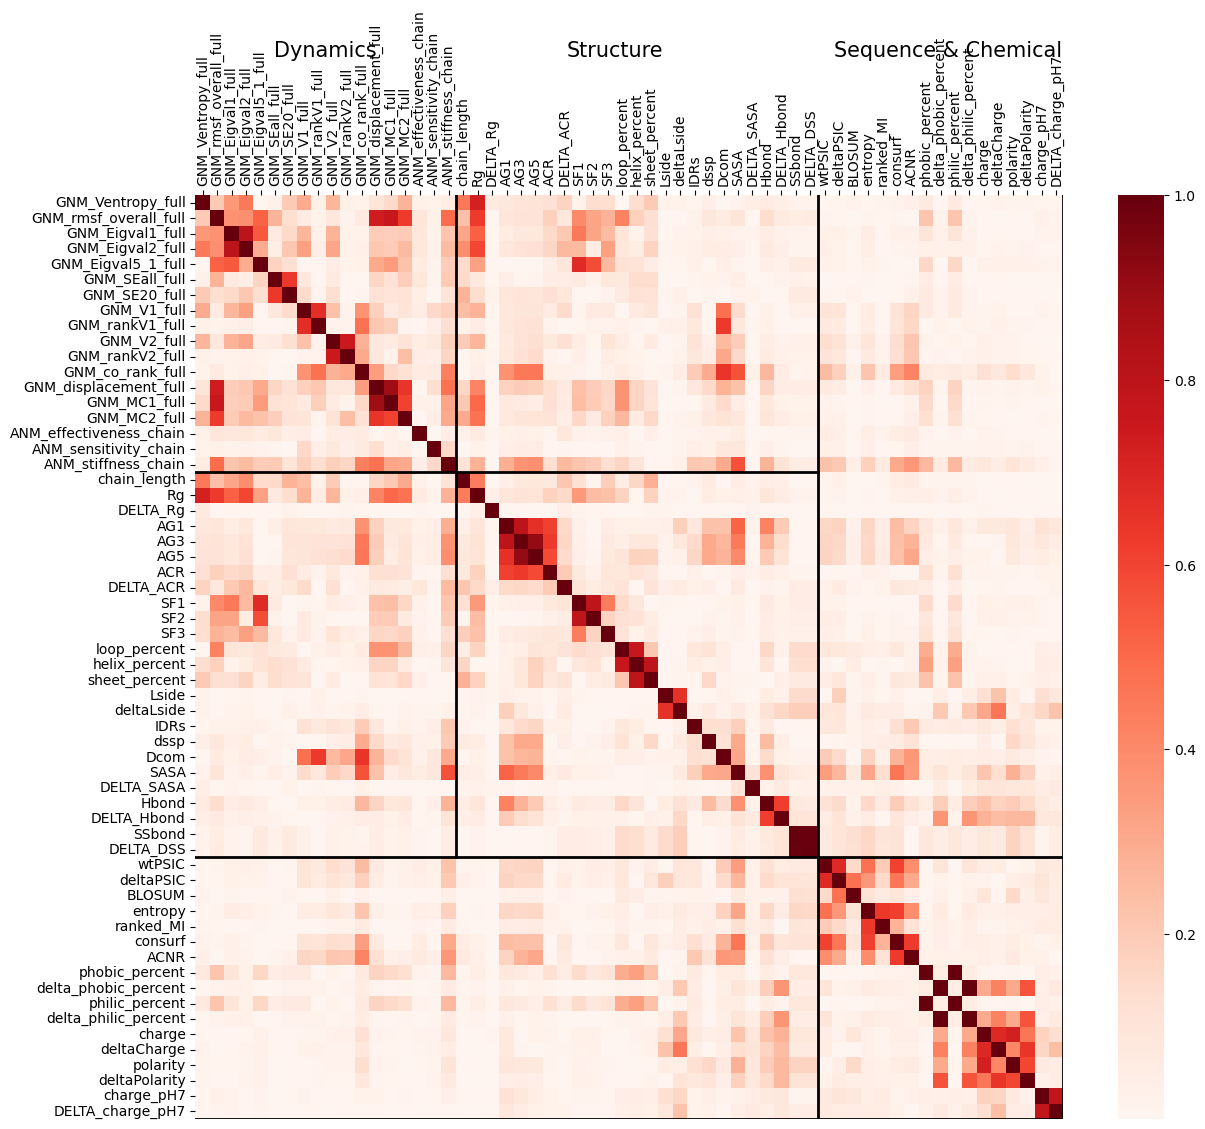

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Choose columns 3 to end
feat = df.iloc[:, 2:]
feat = feat[cols.keys()]
# feat = feat.rename(columns=cols)
cor = feat.corr(method='pearson', numeric_only=True)
# Turn to absolute correlation values
cor = cor.abs()
plt.figure(figsize=(14, 12))
# Create heatmap with feature names on top and left
ax = sns.heatmap(cor, annot=False, cmap=plt.cm.Reds, xticklabels=cor.columns, yticklabels=cor.columns)
# ax.set(xlabel='', ylabel='')
ax.xaxis.tick_top()# and vertical lines
plt.xticks(rotation=90)


n_dynamics = len(dynamics_feat)
n_structure = len(structure_feat)
n_seq = len(seq_feat)
n_feat = n_dynamics + n_structure + n_seq

# Dynamics features
plt.axhline(y=n_dynamics, xmin = 0, xmax = (n_dynamics+n_structure) / n_feat, color='black', linewidth=2)
plt.axvline(x=n_dynamics, ymin=(n_feat-n_dynamics-n_structure) / n_feat, ymax=1, color='black', linewidth=2)
plt.text(9, -9, 'Dynamics', fontsize=15, ha='center')

# Structure features
plt.axhline(y=n_dynamics+n_structure, xmin=0, xmax=(n_dynamics+n_structure+n_seq) / n_feat, color='black', linewidth=2)
plt.axvline(x=n_dynamics+n_structure    , ymin=(n_feat-n_dynamics-n_structure-n_seq) / n_feat, ymax=1, color='black', linewidth=2)
plt.text(11+n_dynamics, -9, 'Structure', fontsize=15, ha='center')

# # SEQ features
plt.axhline(y=n_dynamics+n_structure+n_seq, xmin=0, xmax=(n_dynamics+n_structure+n_seq) / n_feat, color='black', linewidth=2)
plt.axvline(x=n_dynamics+n_structure+n_seq, ymin=(n_feat-n_dynamics-n_structure-n_seq) / n_feat, ymax=1, color='black', linewidth=2)
plt.text(9+n_dynamics+n_structure, -9, 'Sequence & Chemical', fontsize=15, ha='center')

# Make sure the plot is in the center and not let labels/text outward
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# SAVe
# savdir = f'{ROOT_DIR}/data/R20000/stats'
# plt.savefig(f'{savdir}/feature_correlation.png')
# print(f"Feature correlation is saved at {savdir}/feature_correlation.png")
# plt.close()
# plt.show()


In [55]:
cor.to_csv(f'{ROOT_DIR}/data/R20000/stats/feature_correlation.csv')

In [7]:
ranked_corr = cor.unstack().sort_values(ascending=False).drop_duplicates()
# ranked_corr = cor.unstack().sort_values(ascending=False)
print(ranked_corr[ranked_corr > 0.7].__len__() / ranked_corr.__len__())

print('Top highly correlated features:')
for i, (idx, value) in enumerate(ranked_corr.items()):
    print(f'{i+1}. {idx} - {value:.3f}')

0.009340338587273789
Top highly correlated features:
1. ('%Hydrophobic', '%Hydrophilic') - 1.000
2. ('Entropy$_v$', 'Entropy$_v$') - 1.000
3. ('N$_{SS-bond}$', '$\\Delta$N$_{SS-bond}$') - 0.996
4. ('AG$_3$', 'AG$_5$') - 0.910
5. ('$‖C_{i,i}‖$', 'MC${_1}$') - 0.883
6. ('$\\lambda_1$', '$\\lambda_2$') - 0.804
7. ('AG$_1$', 'AG$_3$') - 0.798
8. ('SF$_1$', 'SF$_2$') - 0.796
9. ('%Sheet', '%Helix') - 0.796
10. ('Charge$_{pH7}$', '$\\Delta$Charge$_{pH7}$') - 0.787
11. ('MC${_1}$', 'RMSF$_{all}$') - 0.761
12. ('%Helix', '%Loop') - 0.761
13. ('rank ($‖V_{2,i}‖$)', '$‖V_{2,i}‖$') - 0.752
14. ('$‖C_{i,i}‖$', 'RMSF$_{all}$') - 0.737
15. ('Charge', 'Polarity') - 0.726
16. ('R$_g$', 'Entropy$_v$') - 0.720
17. ('$\\Delta$Charge', 'Charge') - 0.690
18. ('$\\Delta$PSIC$^*$', 'wtPSIC$^*$') - 0.686
19. ('SF$_1$', '$\\lambda_{5-1}$') - 0.681
20. ('rank ($‖V_{1,i}‖$)', '$‖V_{1,i}‖$') - 0.670
21. ('AG$_5$', 'AG$_1$') - 0.663
22. ('$\\Delta$L$_{side}$', 'L$_{side}$') - 0.659
23. ('$\\Delta$Polarity', '$\\De

In [8]:
18/1713

0.010507880910683012

In [ ]:
# Features with high correlation
cutoff = 0.95
high_corr = cor[cor > cutoff]
print('Highly correlated features:')
for i, (idx, value) in enumerate(high_corr.unstack().sort_values(ascending=False).drop_duplicates().items()):
    if value > cutoff:
        print(f'{i+1}. {idx} - {value:.3f}')


# Rank features

In [5]:
from src.utils.settings import ROOT_DIR
import os 
import pandas as pd 
from prody import LOGGER
LOGGER.start(f'{ROOT_DIR}/data/R20000/stats/log.txt')
feat_path = os.path.join(ROOT_DIR, 'data/R20000/final_features.csv')
df = pd.read_csv(feat_path)
sel_cols = ['SAV_coords', 'labels'] + list(cols.keys())
df = df[sel_cols]
# df = df.rename(columns=cols)

# Remove features 
remove_feats = ['philic_percent', 'delta_philic_percent', 'GNM_Ventropy_full', 'DELTA_DSS']
for feat in remove_feats:
    if feat in df.columns:
        df = df.drop(columns=[feat])
        LOGGER.info(f'{feat} is removed from the dataframe')
    else:
        LOGGER.info(f'{feat} is not in the dataframe')


from scipy import stats
import numpy as np
from scipy.stats import wasserstein_distance
import numpy as np

stats_cols = ['feature', 
              'lower_bound', 'upper_bound',
              'pos_mean', 'pos_std', 'pos_sem',
              'neg_mean', 'neg_std', 'neg_sem',
              't-pvalue', 'K-S-pvalue', 'M-W_U_pvalue','wasserstein_distance']
data = []
for feat_name in df.columns[2:]:
    pos = df[df['labels'] == 1][feat_name].values
    neg = df[df['labels'] == 0][feat_name].values
    pos = pos[~pd.isnull(pos)]
    neg = neg[~pd.isnull(neg)]
    pos_mean = pos.mean()
    neg_mean = neg.mean()
    pos_std = pos.std()
    neg_std = neg.std()
    pos_sem = pos_std / np.sqrt(len(pos))
    neg_sem = neg_std / np.sqrt(len(neg))

    _pos_neg = np.concatenate((pos, neg))

    lower_bound = np.percentile(_pos_neg, 2.5)
    upper_bound = np.percentile(_pos_neg, 97.5)
    # Standardize the feature
    fmean = df[feat_name].mean()
    fstd = df[feat_name].std()
    df[feat_name] = (df[feat_name] - fmean) / fstd

    # Retrieve the positive and negative samples
    pos = df[df['labels'] == 1][feat_name].values
    neg = df[df['labels'] == 0][feat_name].values
    pos = pos[~pd.isnull(pos)]
    neg = neg[~pd.isnull(neg)]

    t_test = stats.ttest_ind(pos, neg, equal_var=True)
    ks_test = stats.ks_2samp(pos, neg)
    mannwhitneyu_test = stats.mannwhitneyu(pos, neg)
    wasserstein = wasserstein_distance(pos, neg)
    # data.append([feat_name, t_test.pvalue, ks_test.pvalue, mannwhitneyu_test.pvalue, wasserstein])
    data.append([feat_name,
                 lower_bound, upper_bound,
                 pos_mean, pos_std, pos_sem,
                 neg_mean, neg_std, neg_sem,
                 t_test.pvalue, ks_test.pvalue, mannwhitneyu_test.pvalue, wasserstein])

# Create a dataframe to store the statistics
df_stats = pd.DataFrame(data, columns=stats_cols)
# Rank the features based on the p-values
df_stats['ttest_rank'] = df_stats['t-pvalue'].rank(method='first')
df_stats['KStest_rank'] = df_stats['K-S-pvalue'].rank(method='first')
df_stats['MWUtest_rank'] = df_stats['M-W_U_pvalue'].rank(method='first')
df_stats['wasserstein_dist_rank'] = df_stats['wasserstein_distance'].rank(ascending=False)

##### Take the first 33 features based on the t-test ranking
t_sel_feats = df_stats.sort_values('ttest_rank').head(33)['feature'].values
t_sel_DYNfeats = [feat for feat in t_sel_feats if feat in dynamics_feat.keys()]
t_sel_STRfeats = [feat for feat in t_sel_feats if feat in structure_feat.keys()]
t_set_SEQfeats = [feat for feat in t_sel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the t-test ranking:')
LOGGER.info(f'{len(t_sel_DYNfeats)} Dynamics features: {t_sel_DYNfeats}')
LOGGER.info(f'{len(t_sel_STRfeats)} Structure features: {t_sel_STRfeats}')
LOGGER.info(f'{len(t_set_SEQfeats)} Sequence features: {t_set_SEQfeats}')

##### Take the first 33 features based on the wasserstein_dist_rank ranking
w_sel_feats = df_stats.sort_values('wasserstein_dist_rank').head(33)['feature'].values
w_sel_DYNfeats = [feat for feat in w_sel_feats if feat in dynamics_feat.keys()]
w_sel_STRfeats = [feat for feat in w_sel_feats if feat in structure_feat.keys()]
w_set_SEQfeats = [feat for feat in w_sel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the wasserstein_dist_rank ranking:')
LOGGER.info(f'{len(w_sel_DYNfeats)} Dynamics features: {w_sel_DYNfeats}')
LOGGER.info(f'{len(w_sel_STRfeats)} Structure features: {w_sel_STRfeats}')
LOGGER.info(f'{len(w_set_SEQfeats)} Sequence features: {w_set_SEQfeats}')

# Sum the rank of ttest_rank and washstein_dist_rank
df_stats['sum_rank_ttestANDwasserstein'] = df_stats['ttest_rank'] + df_stats['wasserstein_dist_rank']
##### Take the first 33 features based on the sum_rank_ttestANDwasserstein ranking
tWstsel_feats = df_stats.sort_values('sum_rank_ttestANDwasserstein').head(33)['feature'].values
tWstsel_DYNfeats = [feat for feat in tWstsel_feats if feat in dynamics_feat.keys()]
tWstsel_STRfeats = [feat for feat in tWstsel_feats if feat in structure_feat.keys()]
tWstsel_SEQfeats = [feat for feat in tWstsel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the sum_rank_ttestANDwasserstein ranking:')
LOGGER.info(f'{len(tWstsel_DYNfeats)} Dynamics features: {tWstsel_DYNfeats}')
LOGGER.info(f'{len(tWstsel_STRfeats)} Structure features: {tWstsel_STRfeats}')
LOGGER.info(f'{len(tWstsel_SEQfeats)} Sequence features: {tWstsel_SEQfeats}')

# Sum rank of ttest_rank and KStest_rank
df_stats['sum_rank_ttestANDKStest'] = df_stats['ttest_rank'] + df_stats['KStest_rank']
##### Take the first 33 features based on the sum_rank_ttestANDKStest ranking
tKS_sel_feats = df_stats.sort_values('sum_rank_ttestANDKStest').head(33)['feature'].values
tKS_sel_DYNfeats = [feat for feat in tKS_sel_feats if feat in dynamics_feat.keys()]
tKS_sel_STRfeats = [feat for feat in tKS_sel_feats if feat in structure_feat.keys()]
tKS_sel_SEQfeats = [feat for feat in tKS_sel_feats if feat in seq_feat.keys()]
# Print out each category of features
LOGGER.info('# Top 33 features based on the sum_rank_ttestANDKStest ranking:')
LOGGER.info(f'{len(tKS_sel_DYNfeats)} Dynamics features: {tKS_sel_DYNfeats}')
LOGGER.info(f'{len(tKS_sel_STRfeats)} Structure features: {tKS_sel_STRfeats}')
LOGGER.info(f'{len(tKS_sel_SEQfeats)} Sequence features: {tKS_sel_SEQfeats}')
# Save the statistics to a CSV file
df_stats = df_stats.sort_values(by='ttest_rank', ascending=True)
df_stats.to_csv('data/R20000/stats/test_features_stats.csv', index=False)



@> Logging into file: /mnt/nas_1/YangLab/loci/tandem/data/R20000/stats/log.txt
@> Logging started at 2025-06-22 20:12:58.438704
@> philic_percent is removed from the dataframe
@> delta_philic_percent is removed from the dataframe
@> GNM_Ventropy_full is removed from the dataframe
@> DELTA_DSS is removed from the dataframe
@> # Top 33 features based on the t-test ranking:
@> 9 Dynamics features: ['GNM_co_rank_full', 'ANM_stiffness_chain', 'GNM_V2_full', 'GNM_V1_full', 'GNM_Eigval1_full', 'GNM_rankV2_full', 'GNM_Eigval2_full', 'GNM_rankV1_full', 'ANM_effectiveness_chain']
@> 15 Structure features: ['SASA', 'loop_percent', 'AG1', 'Dcom', 'AG5', 'AG3', 'SSbond', 'Hbond', 'DELTA_Hbond', 'sheet_percent', 'helix_percent', 'Rg', 'IDRs', 'Lside', 'deltaLside']
@> 9 Sequence features: ['wtPSIC', 'deltaPSIC', 'entropy', 'consurf', 'ACNR', 'BLOSUM', 'ranked_MI', 'deltaPolarity', 'deltaCharge']
@> # Top 33 features based on the wasserstein_dist_rank ranking:
@> 8 Dynamics features: ['ANM_stiffness_

In [25]:
data = np.random.randn(100)

lower_bound = np.percentile(data, 2.5)
upper_bound = np.percentile(data, 97.5)

In [44]:
from src.utils.settings import ROOT_DIR
import os 
import pandas as pd 
from prody import LOGGER
LOGGER.start(f'{ROOT_DIR}/data/R20000/stats/log.txt')
feat_path = os.path.join(ROOT_DIR, 'data/R20000/final_features.csv')
df = pd.read_csv(feat_path)
sel_cols = ['SAV_coords', 'labels'] + list(cols.keys())
df = df[sel_cols]
# df = df.rename(columns=cols)

# Remove features 
remove_feats = ['philic_percent', 'delta_philic_percent', 'GNM_Ventropy_full', 'DELTA_DSS']
for feat in remove_feats:
    if feat in df.columns:
        df = df.drop(columns=[feat])
        LOGGER.info(f'{feat} is removed from the dataframe')
    else:
        LOGGER.info(f'{feat} is not in the dataframe')


@> Logging into file: /mnt/nas_1/YangLab/loci/tandem/data/R20000/stats/log.txt
@> Logging started at 2025-05-12 17:25:21.335068
@> philic_percent is removed from the dataframe
@> delta_philic_percent is removed from the dataframe
@> GNM_Ventropy_full is removed from the dataframe
@> DELTA_DSS is removed from the dataframe


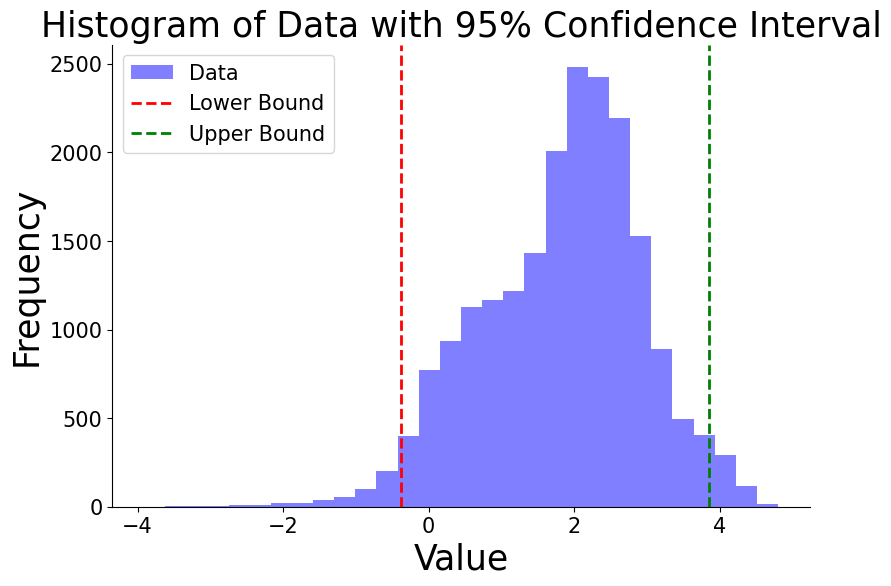

In [40]:
#plot data
plt.figure(figsize=(9, 6))
plt.hist(df['deltaPSIC'].values, bins=30, alpha=0.5, color='b', label='Data')
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2, label='Lower Bound')
plt.axvline(upper_bound, color='g', linestyle='dashed', linewidth=2, label='Upper Bound')
plt.title('Histogram of Data with 95% Confidence Interval', fontsize=25)
plt.xlabel('Value', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=15)




In [26]:
lower_bound, upper_bound

(-1.7623661211119266, 1.902117184764639)

In [207]:
set(tKS_sel_feats) - set(['ANM_stiffness_chain', 'GNM_co_rank_full', 'GNM_V2_full', 'GNM_V1_full', 'GNM_Eigval1_full', 'GNM_Eigval2_full', 'wtBJCE', 'GNM_rankV2_full', 'deltaBJCE', 'GNM_displacement_full', 'ANM_effectiveness_chain', 'SASA', 'loop_percent', 'AG5', 'AG3', 'AG1', 'Dcom', 'Rg', 'sheet_percent', 'DELTA_Hbond', 'deltaLside', 'Hbond', 'helix_percent', 'deltaPSIC', 'wtPSIC', 'consurf', 'entropy', 'ACNR', 'BLOSUM', 'ranked_MI', 'deltaPolarity', 'phobic_percent'])

{'chain_length'}

In [211]:
tKS_sel_STRfeats

df_stats = pd.read_csv('data/R20000/stats/features_stats.csv')
t_sel_feats = df_stats.sort_values('sum_rank_ttestANDKStest').head(33)['feature'].values
sel_DYNfeats = [feat for feat in t_sel_feats if feat in dynamics_feat.keys()]
sel_STRfeats = [feat for feat in t_sel_feats if feat in structure_feat.keys()]
sel_SEQfeats = [feat for feat in t_sel_feats if feat in seq_feat.keys()]
t_sel_feats = sel_DYNfeats + sel_STRfeats + sel_SEQfeats

# Analysis

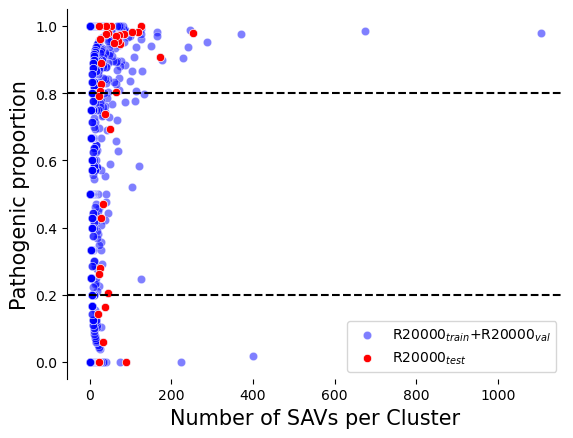

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

SAVs = '../SAVs.csv'
df = pd.read_csv('/mnt/nas_1/YangLab/loci/tandem/data/SAVs.tsv', sep='\t')
df['UniProt_ID'] = df['SAV_coords'].str.split().str[0]

clstr_path = '/mnt/nas_1/YangLab/loci/tandem/data/c30_clstr_May13_full_rhd.csv'
feat_path = '/mnt/nas_1/YangLab/loci/tandem/data/R20000/final_features.csv'
df_clstr = pd.read_csv(clstr_path)
df_feat = pd.read_csv(feat_path)
df_feat['UniProt_ID'] = df_feat['SAV_coords'].str.split().str[0]

_1 = ['P01891', 'P01892', 'P05534', 'P13746', 'P30443', 'P04439']
_2 = ['P01912', 'P04229', 'P13760', 'P20039', 'P01911']
_3 = ['P03989', 'P10319', 'P18464', 'P18465', 'P30460', 'P30464', 'P30466', 'P30475', 'P30479', 'P30480', 'P30481', 'P30484', 'P30490', 'P30491', 'P30685', 'Q04826', 'Q31610', 'P01889']
_4 = ['P04222', 'P30504', 'P30505', 'Q29963', 'Q9TNN7', 'P10321']
_5 = ['Q6DU44', 'P13747']
_6 = ['Q16874', 'P04745']
for _no in [_1, _2, _3, _4, _5, _6]:
# for _no in [_1, _2, _3, _4, _5]:
    _rep_member = df_clstr[df_clstr['member_ID'].str.contains(_no[-1])].rep_member.values[0]
    add_member = ','.join(_no[:-1])
    add_n_member = len(_no[:-1])
    df_clstr.loc[df_clstr['rep_member'] == _rep_member, 'member_ID'] += ',' + add_member
    df_clstr.loc[df_clstr['rep_member'] == _rep_member, 'n_members'] += add_n_member
for i, row in df_clstr.iterrows():
    clstr_member = row['member_ID'].split(',')
    df_clstr_feat = df_feat[df_feat['UniProt_ID'].isin(clstr_member)]
    pathogenic = df_clstr_feat[df_clstr_feat['labels'] == 1]
    benign = df_clstr_feat[df_clstr_feat['labels'] == 0]
    
    n_SAVs = len(df_clstr_feat)
    n_pathogenic = len(pathogenic)
    n_benign = len(benign)

    df_clstr.at[i, 'n_SAVs'] = n_SAVs
    df_clstr.at[i, 'n_pathogenic'] = n_pathogenic
    df_clstr.at[i, 'n_benign'] = n_benign
    df_clstr.at[i, 'pathogenic_percentage'] = n_pathogenic / n_SAVs
    df_clstr.at[i, 'n_pathogenic - n_benign'] = n_pathogenic - n_benign
df_clstr['n_SAVs'] = df_clstr['n_SAVs'].astype(int)

# Sort df_clstr by n_SAVs
df_clstr = df_clstr.sort_values('n_SAVs', ascending=False)
df_clstr = df_clstr.drop(columns=['rep_member', 'rep_member_length', 'member_length', 'member_similarity', 'cluster_no'])
df_clstr = df_clstr.reset_index(drop=True)

# Rank df_clstr by n_SAVs: descending
df_clstr = df_clstr.sort_values('n_SAVs', ascending=False)
df_clstr = df_clstr.reset_index(drop=True)

### Test set
member_IDs = ['P29033', 'P07101', 'Q8IWU9', 'P00439', 'Q9UHC9', 'O15118', 'P22304', 'P30613', 'P14618', 'P35520', 'P11509', 'Q16696', 'P05181', 'P20813', 'P11712', 'P10632', 'P33261', 'P00966', 'P11413', 'Q93099', 'P15848', 'P54802', 'P60484', 'Q06124', 'P09619', 'P16234', 'P10721', 'P07333', 'P78504', 'Q9NR61', 'P52701', 'Q15831', 'P08559', 'P06400', 'P00156', 'P78527', 'Q14353', 'Q13224', 'Q12879', 'Q9H251', 'P51648', 'P30838', 'P18074', 'O94759', 'Q8TD43', 'P00813', 'O14733', 'P36507', 'P45985', 'Q02750', 'Q96L73', 'O43240', 'P06870', 'P07288', 'P20151', 'O60259', 'Q9Y5K2', 'P23946', 'P07477', 'Q92876', 'P46597', 'P03891']
# Concatenate the row of member_ID in df_clstr
df_test = pd.DataFrame(columns=df_clstr.columns)
for i, row in df_clstr.iterrows():
    member_ID = row['member_ID'].split(',')
    if any([True for ID in member_ID if ID in member_IDs]):
        df_test = pd.concat([df_test, row.to_frame().T], ignore_index=True)
##############

patho_percent = []
nSAV_per_clstr = []
for i, row in df_clstr.iterrows():
    member_ID = row['member_ID'].split(',')
    df_clstr_feat = df_feat[df_feat['UniProt_ID'].isin(member_ID)]
    n_SAVs = len(df_clstr_feat)
    pathogenic = df_clstr_feat[df_clstr_feat['labels'] == 1]
    pathogenic_percentage = len(pathogenic) / n_SAVs
    patho_percent.append(pathogenic_percentage)
    nSAV_per_clstr.append(n_SAVs)

# Plot patho_percent vs nSAV_per_UniProt
sns.scatterplot(x=nSAV_per_clstr, y=patho_percent, color='b', alpha=0.5, label=r'R20000$_{train}$+R20000$_{val}$')
plt.xlabel('Number of SAVs per Cluster', fontsize=15)
plt.ylabel('Pathogenic proportion', fontsize=15)

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.text(0.7, 0.8, f'Σ R20000: {sum(nSAV_per_clstr)}', fontsize=12, transform=plt.gca().transAxes)
# plt.text(0.7, 0.7, r'Σ R20000$_{test}$: 2043', fontsize=12, transform=plt.gca().transAxes, color='r')
# plt.text(0.7, 0.8, f'Σ R20000$_test$ = {len(df_test)}', fontsize=12, transform=plt.gca().transAxes)
plt.xticks([0, 200, 400, 600, 800, 1000])

############################################################################################################
# Plot df_test pathogenic_percentage vs n_SAVs
patho_percent = []
nSAV_per_clstr = []
for i, row in df_test.iterrows():
    member_ID = row['member_ID'].split(',')
    df_clstr_feat = df_feat[df_feat['UniProt_ID'].isin(member_ID)]
    n_SAVs = len(df_clstr_feat)
    pathogenic = df_clstr_feat[df_clstr_feat['labels'] == 1]
    pathogenic_percentage = len(pathogenic) / n_SAVs
    patho_percent.append(pathogenic_percentage)
    nSAV_per_clstr.append(n_SAVs)

# Plot patho_percent vs nSAV_per_UniProt
sns.scatterplot(x=nSAV_per_clstr, y=patho_percent, color='r', label=r'R20000$_{test}$')
############################################################################################################
# plt.title(r'R20000: 20,290 SAVs; Σ R20000$_{test}$: 2,043 SAVs', fontsize=15)
# Plot a vertical line at x = 60
plt.axhline(0.8, color='k', linestyle='--')
plt.axhline(0.2, color='k', linestyle='--')
plt.show()
# plt.savefig('/mnt/nas_1/YangLab/loci/tandem/data/R20000/images/pathogenic_percentage.png', dpi=300)
# plt.close()

In [9]:
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/mnt/nas_1/YangLab/loci/NativeEnsembleWeb_copy/improve/train')


import os 
import sys
from src.utils.settings import TANDEM_R20000, CLUSTER, dynamics_feat, structure_feat, seq_feat, cols, TANDEM_GJB2
from src.features import TANDEM_FEATS
from src.train.run import getR20000, getTestset

sel_feats = TANDEM_FEATS['v1.1']
folds, R20000, preprocess_feat = getR20000(TANDEM_R20000, CLUSTER, feat_names=sel_feats)

n_folds = len(folds)
train_ratio = [folds[i]['train']['ratio'] for i in range(n_folds)]
val_ratio = [folds[i]['val']['ratio'] for i in range(n_folds)]
test_ratio = [folds[i]['test']['ratio'] for i in range(n_folds)]

index = [0, 1, 2, 3, 4]
for i in index:
    plt.bar(i+0.4, train_ratio[i], color='blue', width=0.4, edgecolor='w')
    plt.bar(i+0.2, val_ratio[i], color='red', width=0.4, edgecolor='w')
    plt.bar(i, test_ratio[i], color='g', width=0.4, edgecolor='w')
    plt.text(i+0.53, train_ratio[i], '{:.2f}'.format(train_ratio[i]), ha='center', va='bottom')
    plt.text(i+0.35, val_ratio[i], '{:.2f}'.format(val_ratio[i]), ha='center', va='bottom')
    plt.text(i, test_ratio[i], '{:.2f}'.format(test_ratio[i]), ha='center', va='bottom')

# Create legend
plt.bar(0, 0, color='blue', label=r'R20000$_{train}$')
plt.bar(0, 0, color='red', label=r'R20000$_{val}$')
plt.bar(0, 0, color='g', label=r'R20000$_{test}$')

plt.ylabel('Pathogenic / benign ratio', fontsize=15)
# plt.title('Ratio description in each set')
plt.xticks([0.2, 1.2, 2.2, 3.2, 4.2], ('Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'))
plt.legend(loc=[0.9, 0.8], fontsize=10)
# plt.legend(fontsize=10)

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()

# plt.show()
plt.savefig('ratio_description.png')
plt.close()

2025-06-23 09:18:56.281074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Tensorflow Version: 2.17.0
**************************************************
Missing values in the dataframe:
consurf: 		 2
ACNR: 		 2
deltaPSIC: 		 1
SF1: 		 11
SF2: 		 11
SF3: 		 11
entropy: 		 3769
ranked_MI: 		 3769
Assigning the mean value of feature to the missing values
Assigning mean value to consurf: -0.23
Assigning mean value to ACNR: -0.18
Assigning mean value to deltaPSIC: 1.83
Assigning mean value to SF1: 0.50
Assigning mean value to SF2: 0.67
Assigning mean value to SF3: 0.76
Assigning mean value to entropy: 1.65
Assigning mean value to ranked_MI: 0.48
**************************************************
1 members: 1428 clusters
2 members: 226 clust

In [2]:
df_test_20 = df_test[df_test['pathogenic_percentage'] < 0.2]
df_test_80 = df_test[df_test['pathogenic_percentage'] > 0.8]
df_test_20_80 = df_test[(df_test['pathogenic_percentage'] >= 0.2) & (df_test['pathogenic_percentage'] <= 0.8)]

test_20_mem = [i.split(',') for i in df_test_20['member_ID'].values]
test_20_mem = [item for sublist in test_20_mem for item in sublist]
test_80_mem = [i.split(',') for i in df_test_80['member_ID'].values]
test_80_mem = [item for sublist in test_80_mem for item in sublist]
test_20_80_mem = [i.split(',') for i in df_test_20_80['member_ID'].values]
test_20_80_mem = [item for sublist in test_20_80_mem for item in sublist]
test_mem = test_20_mem + test_80_mem + test_20_80_mem

df_test_20.shape, df_test_80.shape, df_test_20_80.shape

((5, 7), (21, 7), (8, 7))

In [4]:
from src.utils.settings import TANDEM_GJB2
from src.train.transfer_learning import import_data
from src.train.modules import Preprocessing, np_to_dataset
from src.features import TANDEM_FEATS

folds, R20000, preprocess_feat, test_knw, test_unk, input_shape = import_data(TANDEM_GJB2)

feat_names = TANDEM_FEATS['v1.1']

df_test_feat = df_feat[df_feat['UniProt_ID'].isin(test_mem)]
test_feats = df_test_feat[feat_names].values
test_feats = preprocess_feat.fill_na_mean(test_feats)
test_feats = preprocess_feat.normalize(test_feats)
test_labels = df_test_feat['labels'].values
test_labels = Preprocessing.one_hot_encoding_labels(test_labels, 2)
test_ds = np_to_dataset(test_feats, test_labels, shuffle=False, batch_size=300)

df_test_20_feat = df_feat[df_feat['UniProt_ID'].isin(test_20_mem)]
test_20_feats = df_test_20_feat[feat_names].values
test_20_feats = preprocess_feat.fill_na_mean(test_20_feats)
test_20_feats = preprocess_feat.normalize(test_20_feats)
test_20_labels = df_test_20_feat['labels'].values
test_20_labels = Preprocessing.one_hot_encoding_labels(test_20_labels, 2)
test_20_ds = np_to_dataset(test_20_feats, test_20_labels, shuffle=False, batch_size=300)

df_test_80_feat = df_feat[df_feat['UniProt_ID'].isin(test_80_mem)]
test_80_feats = df_test_80_feat[feat_names].values
test_80_feats = preprocess_feat.fill_na_mean(test_80_feats)
test_80_feats = preprocess_feat.normalize(test_80_feats)
test_80_labels = df_test_80_feat['labels'].values
test_80_labels = Preprocessing.one_hot_encoding_labels(test_80_labels, 2)
test_80_ds = np_to_dataset(test_80_feats, test_80_labels, shuffle=False, batch_size=300)

df_test_20_80_feat = df_feat[df_feat['UniProt_ID'].isin(test_20_80_mem)]
test_20_80_feats = df_test_20_80_feat[feat_names].values
test_20_80_feats = preprocess_feat.fill_na_mean(test_20_80_feats)
test_20_80_feats = preprocess_feat.normalize(test_20_80_feats)
test_20_80_labels = df_test_20_80_feat['labels'].values
test_20_80_labels = Preprocessing.one_hot_encoding_labels(test_20_80_labels, 2)
test_20_80_ds = np_to_dataset(test_20_80_feats, test_20_80_labels, shuffle=False, batch_size=300)

len(df_test_20_feat), len(df_test_80_feat), len(df_test_20_80_feat), len(df_test_feat)

**************************************************
Feature selection based on ttest rank
/mnt/nas_1/YangLab/loci/tandem/data/R20000/stats/features_stats.csv
Feature set: ['GNM_co_rank_full', 'ANM_stiffness_chain', 'GNM_V2_full', 'GNM_V1_full', 'GNM_Eigval1_full', 'GNM_rankV2_full', 'GNM_Eigval2_full', 'GNM_rankV1_full', 'ANM_effectiveness_chain', 'SASA', 'loop_percent', 'AG1', 'Dcom', 'AG5', 'AG3', 'SSbond', 'Hbond', 'DELTA_Hbond', 'sheet_percent', 'helix_percent', 'Rg', 'IDRs', 'Lside', 'deltaLside', 'entropy', 'wtPSIC', 'deltaPSIC', 'consurf', 'ACNR', 'BLOSUM', 'ranked_MI', 'deltaPolarity', 'deltaCharge']
**************************************************
Missing values in the dataframe:
consurf: 		 2
ACNR: 		 2
deltaPSIC: 		 1
SF1: 		 11
SF2: 		 11
SF3: 		 11
entropy: 		 3769
ranked_MI: 		 3769
Assigning the mean value of feature to the missing values
Assigning mean value to consurf: -0.23
Assigning mean value to ACNR: -0.18
Assigning mean value to deltaPSIC: 1.83
Assigning mean val

(202, 1578, 263, 2043)

In [14]:
import os 
import tensorflow as tf

imp_opt_dir = '/mnt/nas_1/YangLab/loci/tandem/models/different_number_of_layers/20250423-1234-tandem'
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from src.train.run import get_config
from src.train.modules import build_optimizer

cfg = get_config(33, 6, 50)
optimizer = build_optimizer(cfg)
os.listdir(f'{imp_opt_dir}/n_hidden-5')
_6hl = os.path.join(imp_opt_dir, 'n_hidden-5')
_6hl_models = [os.path.join(_6hl, f'model_fold_{i}.h5') for i in range(1, 6)]
_6hl_models = [tf.keras.models.load_model(model) for model in _6hl_models]
_6hl_models[0].compile(optimizer=optimizer, loss=cfg.training.loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
_6hl_models[1].compile(optimizer=optimizer, loss=cfg.training.loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
_6hl_models[2].compile(optimizer=optimizer, loss=cfg.training.loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
_6hl_models[3].compile(optimizer=optimizer, loss=cfg.training.loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
_6hl_models[4].compile(optimizer=optimizer, loss=cfg.training.loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])


import numpy as np
acc_20 = []
acc_80 = []
acc_20_80 = []
acc = []
for model in _6hl_models:
    acc_20.append(model.evaluate(test_20_ds)[1]*100)
    acc_80.append(model.evaluate(test_80_ds)[1]*100)
    acc_20_80.append(model.evaluate(test_20_80_ds)[1]*100)
    acc.append(model.evaluate(test_ds)[1]*100)

# print(f'Test accuracy: {sum(acc) / len(acc)} ± {np.std(acc) / np.sqrt(len(acc))}')
# print(f'Test_20 accuracy: {sum(acc_20) / len(acc_20)} ± {np.std(acc_20) / np.sqrt(len(acc_20))}')
# print(f'Test_80 accuracy: {sum(acc_80) / len(acc_80)} ± {np.std(acc_80) / np.sqrt(len(acc_80))}')
# print(f'Test_20_80 accuracy: {sum(acc_20_80) / len(acc_20_80)} ± {np.std(acc_20_80) / np.sqrt(len(acc_20_80))}')
print("Test accuracy: %.1f±%.1f%%" % (sum(acc) / len(acc), np.std(acc) / np.sqrt(len(acc))))
print("Test_20 accuracy: %.1f±%.1f%%" % (sum(acc_20) / len(acc_20), np.std(acc_20) / np.sqrt(len(acc_20))))
print("Test_80 accuracy: %.1f±%.1f%%" % (sum(acc_80) / len(acc_80), np.std(acc_80) / np.sqrt(len(acc_80))))
print("Test_20_80 accuracy: %.1f±%.1f%%" % (sum(acc_20_80) / len(acc_20_80), np.std(acc_20_80) / np.sqrt(len(acc_20_80))))


ERROR:src.train.run:Input Layer: 33
ERROR:src.train.run:Model Configuration: 
+-----------+------------+------------+--------------+----------------+----+--------+-----------+
|   Layer   | Activation | Batch Norm | Dropout Rate |  Initializer   | L1 |   L2   | N Neurons |
+-----------+------------+------------+--------------+----------------+----+--------+-----------+
|   Input   |     -      |     -      |     0.0      |       -        | -  |   -    |     33    |
| hidden_00 |    gelu    |   False    |     0.0      | glorot_uniform | 0  | 0.0001 |     33    |
| hidden_01 |    gelu    |   False    |     0.0      | glorot_uniform | 0  | 0.0001 |     33    |
| hidden_02 |    gelu    |   False    |     0.0      | glorot_uniform | 0  | 0.0001 |     33    |
| hidden_03 |    gelu    |   False    |     0.0      | glorot_uniform | 0  | 0.0001 |     33    |
| hidden_04 |    gelu    |   False    |     0.0      | glorot_uniform | 0  | 0.0001 |     33    |
| hidden_05 |    gelu    |   False    | 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step - accuracy: 0.6089 - auc: 0.6720 - loss: 0.6923 - precision: 0.6089 - recall: 0.6089
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - auc: 0.9373 - loss: 0.3641 - precision: 0.8704 - recall: 0.8704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6654 - auc: 0.7328 - loss: 0.6531 - precision: 0.6654 - recall: 0.6654
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8235 - auc: 0.8964 - loss: 0.4281 - precision: 0.8235 - recall: 0.8235
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.5891 - auc: 0.6655 - loss: 0.7026 - precision: 0.5891 - recall: 0.5891
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9046 - auc: 0.9607 - loss: 0.3084 - precision: 0.9046 - recall: 0.9046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6616 - auc: 0.7116 - loss: 0.6783 - precision: 0.6616 - recall: 0.6616
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - auc: 0.9174 - loss: 0.3900 - precision: 0.8444 - recall: 0.8444
1/1 ━━━━━━━━━━━━━━━